# **CS5785 Homework 4**

## PE2. Random Forests for Image Approximation

[Yufan Zhang](https://yufanbruce.com/) (yz2894)

[Tian Jin](https://koapushjin.cargo.site/) (tj299)


In [159]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Ignore any warnings
import warnings

warnings.filterwarnings("ignore")

In [160]:
# PATH variables
DATA_PATH = "./data/"
IMG_PATH = "./img/"
RESULT_PATH = "./result/"

if not os.path.exists(IMG_PATH):
    os.makedirs(IMG_PATH)

if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

**Random Forests for Image Approximation**

In this question, you will use random forest regression to approximate an image by learning a function, $f : R_2 → R$, that takes image (x, y) coordinates as input and outputs pixel brightness. This way, the function learns to approximate areas of the
image that it has not seen before.

1. Start with an image of the Mona Lisa. If you don’t like the Mona Lisa, pick another interesting image of your choice.

2. Preprocessing the input. To build your “training set,” uniformly sample 5,000 random (x, y) coordinate locations.

   - What other preprocessing steps are necessary for random forests inputs? Describe them, implement them, and justify your decisions. In particular, do you need to perform mean subtraction, standardization, or unit-normalization?

3. Preprocessing the output. Sample pixel values at each of the given coordinate locations. Each pixel contains red, green, and blue intensity values, so decide how you want to handle this. There are several options available to you:

   - Convert the image to grayscale
   - Regress all three values at once, so your function maps (x, y) coordinates to (r, g, b) values: $f : R_2 → R_3$
   - Learn a different function for each channel, $f_{Red} : R^2 → R$, and likewise for $f_{Green}$, $f_{Blue}$.

   Note that you may need to rescale the pixel intensities to lie between 0.0 and 1.0. (The default for pixel values may be between 0 and 255, but your image library may have different defaults.)

   What other preprocessing steps are necessary for random regression forest outputs? Describe them, implement them, and justify your decisions.

4. To build the final image, for each pixel of the output, feed the pixel coordinate through the random forest and color the resulting pixel with the output prediction. You can then use `imshow` to view the result. (If you are using grayscale, try `imshow(Y, cmap=‘gray’)` to avoid fake-coloring). You may use any implementation of random forests, but you should understand the implementation and you must cite your sources.

5. Experimentation.

   1. Repeat the experiment for a random forest containing a single decision tree, but with depths 1, 2, 3, 5, 10, and 15. How does depth impact the result? Describe in detail why.
   2. Repeat the experiment for a random forest of depth 7, but with number of trees equal to 1, 3, 5, 10, and 100. How does the number of trees impact the result? Describe in detail why.
   3. As a simple baseline, repeat the experiment using a k-NN regressor, for $k = 1$. This means that every pixel in the output will equal the nearest pixel from the “training set.” Compare and contrast the outlook: why does this look the way it does? You may use an existing implementation of k-NN but make sure to cite your source.
   4. Experiment with different pruning strategies of your choice.

6. Analysis
   1. What is the decision rule at each split point? Write down the 1-line formula for the split point at the root node for one of the trained decision trees inside the forest. Feel free to define any variables you need.
   2. Why does the resulting image look like the way it does? What shape are the patches of color, and how are they arranged?


### a. Load the Mona Lisa image


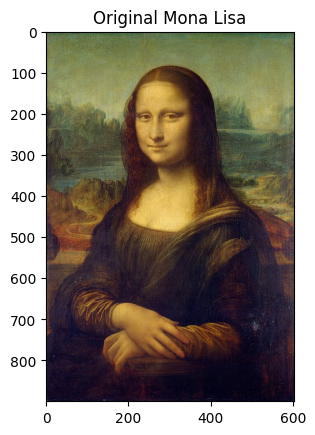

Shape of the image: (900, 604, 3)


In [161]:
import requests
from io import BytesIO

# Download the image from the web
url = "http://tinyurl.com/mona-lisa-small"
response = requests.get(url)
mona_lisa = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(mona_lisa)
plt.title("Original Mona Lisa")
plt.savefig(
    RESULT_PATH + "mona_lisa.png",
    bbox_inches="tight",
)
plt.show()

# Convert the image to a NumPy array
mona_lisa = np.array(mona_lisa)
height, width, _ = mona_lisa.shape

# Generate all coordinates
all_coords = np.array([[x, y] for y in range(height) for x in range(width)])
print(f"Shape of the image: {mona_lisa.shape}")

In [162]:
# # Load the Mona Lisa image from the disk
# mona_lisa = Image.open(IMG_PATH + "mona_lisa.jpg")
# plt.imshow(mona_lisa)

# mona_lisa = np.array(mona_lisa)
# height, width, _ = mona_lisa.shape
# all_coords = np.array([[x, y] for y in range(height) for x in range(width)])
# print(f"Shape of the image: {mona_lisa.shape}")

### b. Preprocessing the input


In [163]:
# Generate 5,000 random coordinates
height, width, _ = mona_lisa.shape
num_samples = 5000
x_coords = np.random.randint(0, width, num_samples)
y_coords = np.random.randint(0, height, num_samples)

# Combine x and y coordinates
coords = np.column_stack((x_coords, y_coords))

print(f"Shape of the coordinates: {coords.shape}")

Shape of the coordinates: (5000, 2)


### c. Preprocessing the output

Regress all three values at once, so your function maps (x, y) coordinates to (r, g, b) values: $f : R_2 → R_3$


In [164]:
# Extract pixel values (RGB) at these coordinates
pixel_values = mona_lisa[y_coords, x_coords]

# Normalize pixel values to be between 0 and 1
pixel_values_normalized = pixel_values / 255.0

print(f"Shape of the pixel values: {pixel_values_normalized.shape}")

Shape of the pixel values: (5000, 3)


### d. Build the final image


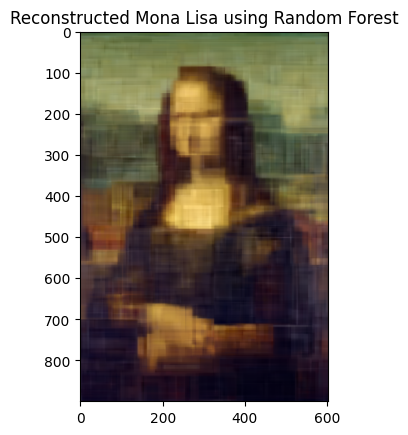

In [165]:
# Create and train the Random Forest model
model = RandomForestRegressor(
    n_estimators=100, random_state=42
)  # 100 trees in the forest
model.fit(coords, pixel_values_normalized)

# Predicting RGB values for each pixel in the image
predicted_pixel_values = model.predict(all_coords)

# Reshape the predicted values to the shape of the image
predicted_image = predicted_pixel_values.reshape(height, width, 3)

# Visualize the reconstructed image
plt.imshow(predicted_image)
plt.title("Reconstructed Mona Lisa using Random Forest")
plt.savefig(
    RESULT_PATH + "reconstructed_mona_lisa_random_forest.png",
    bbox_inches="tight",
)
plt.show()

### e. Experimentation


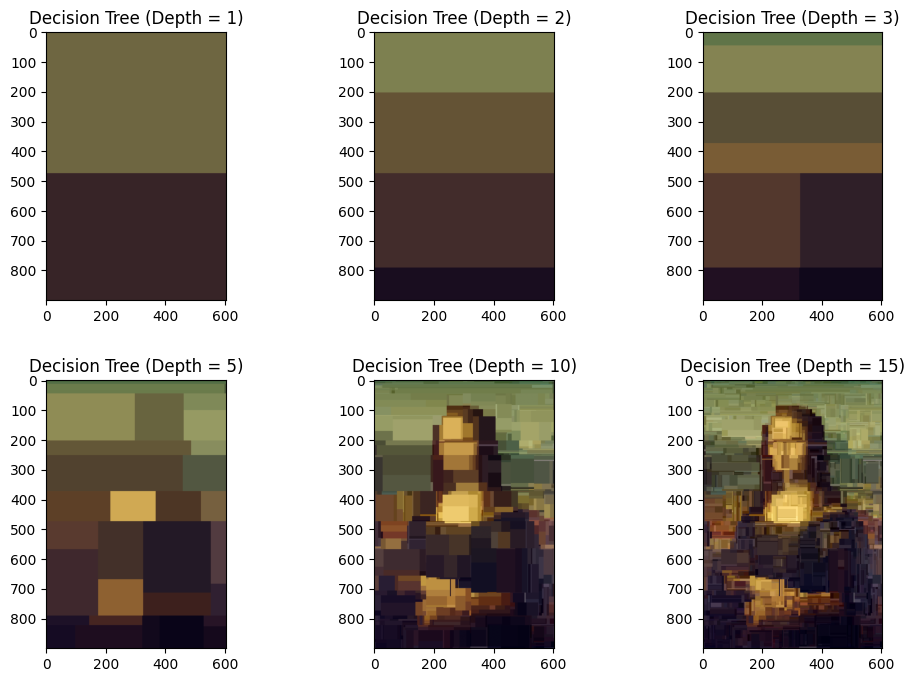

In [166]:
# 1. Single Decision Tree at Various Depths
def predict_with_decision_tree(depth):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(coords, pixel_values_normalized)
    predicted_pixel_values = model.predict(all_coords).reshape(height, width, 3)
    plt.imshow(predicted_pixel_values)
    plt.title(f"Decision Tree (Depth = {depth})")


# Experiment with different depths
plt.figure(figsize=(12, 8))
for i, depth in enumerate([1, 2, 3, 5, 10, 15]):
    plt.subplot(2, 3, i + 1)
    plt.subplots_adjust(hspace=0.3)
    predict_with_decision_tree(depth)

plt.savefig(
    RESULT_PATH + "reconstructed_mona_lisa_experiment1.png",
    bbox_inches="tight",
)

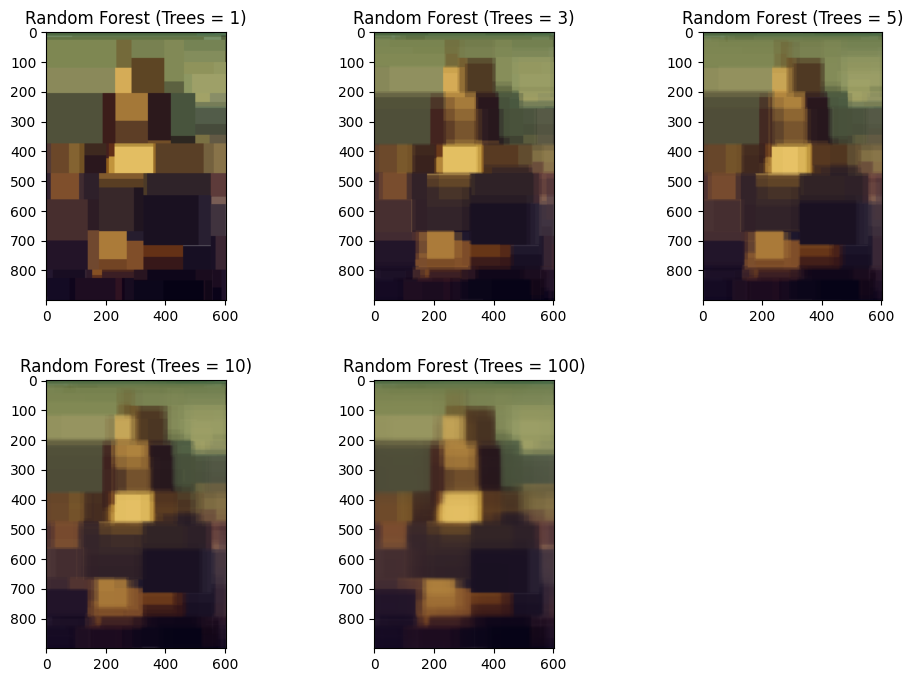

In [167]:
# 2. Random Forest with Varying Number of Trees
# Function to create and train a random forest, then predict the whole image
def predict_with_random_forest(n_trees):
    model = RandomForestRegressor(n_estimators=n_trees, max_depth=7, random_state=42)
    model.fit(coords, pixel_values_normalized)
    predicted_pixel_values = model.predict(all_coords).reshape(height, width, 3)
    plt.imshow(predicted_pixel_values)
    plt.title(f"Random Forest (Trees = {n_trees})")


# Experiment with different numbers of trees
# Save the images into one figure
plt.figure(figsize=(12, 8))
for i, n_trees in enumerate([1, 3, 5, 10, 100]):
    plt.subplot(2, 3, i + 1)
    plt.subplots_adjust(hspace=0.3)
    predict_with_random_forest(n_trees)

plt.savefig(
    RESULT_PATH + "reconstructed_mona_lisa_experiment2.png",
    bbox_inches="tight",
)

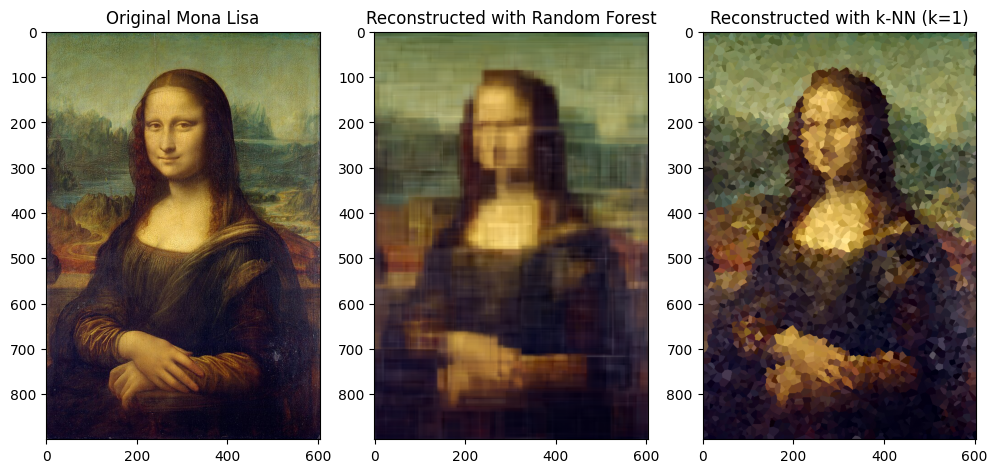

In [168]:
# 3. k-NN Regressor Experiment
# Train and predict with k-NN
knn_model = KNeighborsRegressor(n_neighbors=1)
knn_model.fit(coords, pixel_values_normalized)
predicted_pixel_values_knn = knn_model.predict(all_coords).reshape(height, width, 3)

# Compare to the original image and the random forest
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(mona_lisa)
plt.title("Original Mona Lisa")
plt.subplot(1, 3, 2)
plt.imshow(predicted_image)
plt.title("Reconstructed with Random Forest")
plt.subplot(1, 3, 3)
plt.imshow(predicted_pixel_values_knn)
plt.title("Reconstructed with k-NN (k=1)")
plt.savefig(
    RESULT_PATH + "reconstructed_mona_lisa_experiment3.png",
    bbox_inches="tight",
)

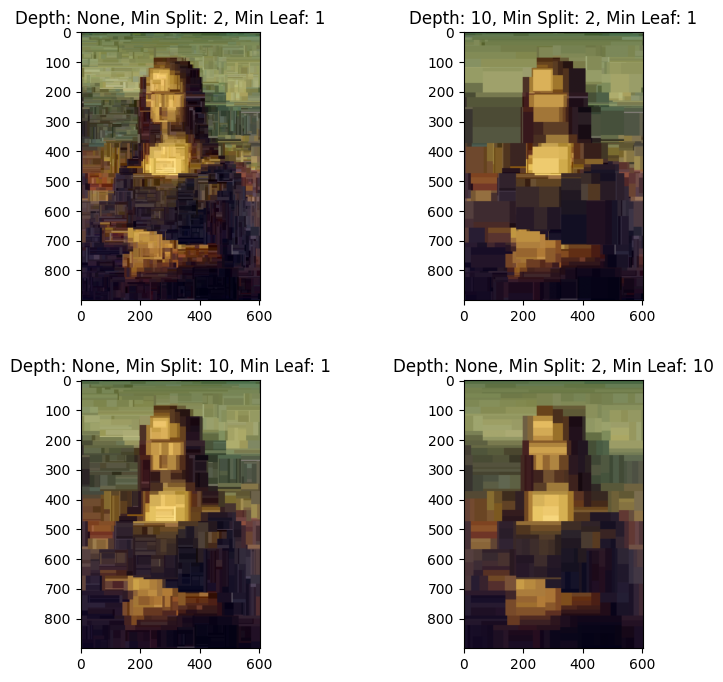

In [169]:
# 4. Decision Tree with Different Pruning Strategies
def experiment_pruning(max_depth=None, min_samples_split=2, min_samples_leaf=1):
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    model.fit(coords, pixel_values_normalized)
    predicted_pixel_values = model.predict(all_coords).reshape(height, width, 3)
    plt.imshow(predicted_pixel_values)
    title = "Depth: {}, Min Split: {}, Min Leaf: {}".format(
        max_depth, min_samples_split, min_samples_leaf
    )
    plt.title(title)


# Experiment with different pruning parameters
# Save the images into one figure
plt.figure(figsize=(12, 8))

# No pruning (baseline)
plt.subplot(2, 2, 1)
experiment_pruning()

# Limiting depth
plt.subplot(2, 2, 2)
experiment_pruning(max_depth=10)

# Increasing minimum samples for split
plt.subplot(2, 2, 3)
experiment_pruning(min_samples_split=10)

# Increasing minimum samples in leaf
plt.subplot(2, 2, 4)
experiment_pruning(min_samples_leaf=10)

plt.subplots_adjust(hspace=0.3, wspace=-0.3)
plt.savefig(
    RESULT_PATH + "reconstructed_mona_lisa_experiment4.png",
    bbox_inches="tight",
)

### f. Analysis


In [170]:
# Train the Random Forest model the same way as before
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(coords, pixel_values_normalized)
feature_names = ["x_coord", "y_coord"]

# Extract one of the trees from the forest
single_tree = rf.estimators_[0]  # Grabbing the first decision tree

# Get the decision rule for the root node
# Feature used for the split
feature = feature_names[single_tree.tree_.feature[0]]
threshold = single_tree.tree_.threshold[0]  # Threshold value for the split
print(f"Decision boundary: {feature} < {threshold}")

Decision boundary: y_coord < 473.0


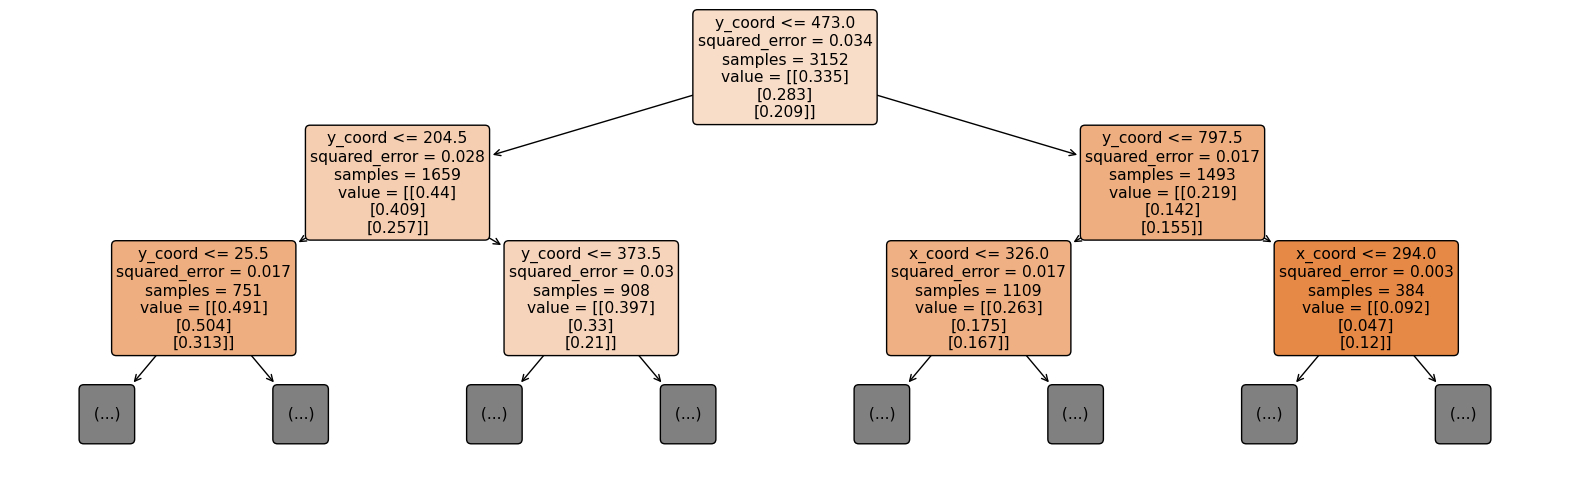

In [171]:
from sklearn import tree

# Visualize the first 2 levels of the tree
plt.figure(figsize=(20, 6))
tree.plot_tree(
    single_tree, max_depth=2, filled=True, feature_names=feature_names, rounded=True
)
plt.savefig(
    RESULT_PATH + "decision_tree.png",
    bbox_inches="tight",
)
plt.show()

---

## WE2. Ensemble Model

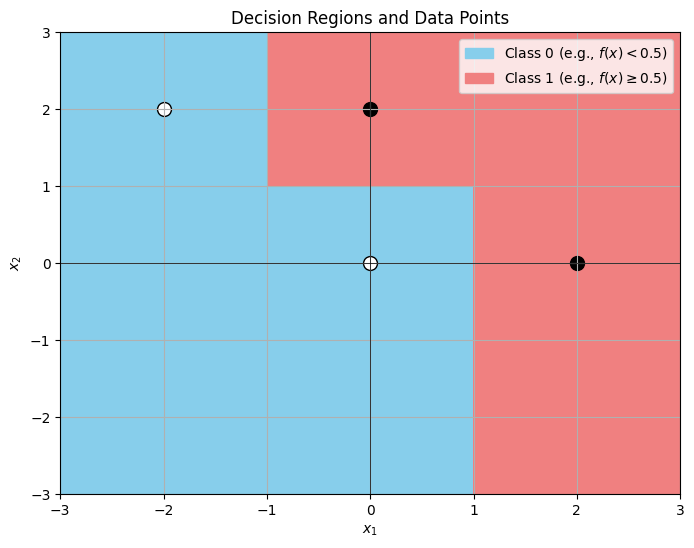

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Define the threshold functions as per the discussion
def g1(x):
    return 1 if x[1] > 1 else 0


def g2(x):
    return 1 if x[0] > 1 else 0


def g3(x):
    return 1 if x[0] > -1 else 0


# Define the ensemble model
def f(x):
    return 0.2 * (g1(x) + g2(x) + 2 * g3(x))


# Create a meshgrid for visualization
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))

# Apply the ensemble model to each point in the grid
Z = np.array([f([x, y]) for x, y in zip(np.ravel(xx), np.ravel(yy))])

# Reshape the output to match xx and yy
Z = Z.reshape(xx.shape)

# Plot the decision regions where the points'z < 0.5 will be in white, and z >= 0.5 will be in blue, labeling the regions with different colors
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=["skyblue", "lightcoral"])


# Annotate the points
data_points = np.array([[0, 2], [2, 0], [0, 0], [-2, 2]])
labels = np.array([1, 1, 0, 0])
for (x, y), label in zip(data_points, labels):
    plt.scatter(x, y, c="black" if label == 1 else "white", edgecolors="k", s=100)

# Formatting the plot
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Decision Regions and Data Points")
plt.grid(True)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
# Create patch objects for the legend
class0_patch = mpatches.Patch(color="skyblue", label="Class 0 (e.g., $f(x) < 0.5$)")
class1_patch = mpatches.Patch(
    color="lightcoral", label="Class 1 (e.g., $f(x) \geq 0.5$)"
)

# Add the legend to the plot
plt.legend(handles=[class0_patch, class1_patch], loc="upper right")
plt.savefig(
    RESULT_PATH + "decision_regions.png",
    bbox_inches="tight",
)
plt.show()

In [173]:
print(f"Value of white points: {f([-2, 2]), f([0, 0])}")
print(f"Value of black points: {f([2, 0]), f([0, 2])}")

Value of white points: (0.2, 0.4)
Value of black points: (0.6000000000000001, 0.6000000000000001)
